# Cleaning Melbourne sensor footfall data 
This script cleans the footfall data for Melbourne

#### Code initialisation

In [1]:
from os.path import samefile

import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
from datetime import date, datetime

# Add the path two directories up from the current notebook location
sys.path.append(os.path.abspath(os.path.join('..')))
# Now import the function from DataPrepFunctions.py
from DataPrepFunctions import check_and_prepare_data_directory

#### Import pedestrian count data

[ ] TODO: Need to upload the data to a permanent location and check that the download/extract (`check_and_prepare_data_directory`) function works.

**Activate the cell below if you don't already have all of the required input data and need to do a bulk download** 

The sensor data are in two files, 'old' and 'new'. See the [README](../../../README.md) for more information. We read them both and then consolidate them into one dataframe.

In [2]:
sensor_counts_old = pd.read_csv('../../Data/FootfallData/Pedestrian_Counting_System_Monthly_counts_per_hour_may_2009_to_14_dec_2022.csv')  # Origial file

In [3]:
sensor_counts_new  = pd.read_csv("../../Data/FootfallData/pedestrian-counting-system-monthly-counts-per-hour.csv")

#### Rename columns to all lowercase and standardise (to facilitate joining)

In [4]:
# Simply rename columns in the old file
sensor_counts_old.rename({'Date_Time': 'datetime', 'Year': 'year', 'Month':'month', 'Mdate': 'mdate', 
                      'Day': 'day', 'Time': 'time', 'Sensor_ID': 'sensor_id', 'Hourly_Counts': 'hourly_counts'}, 
                     axis = 1, inplace = True)
# Properly format datetime in old file
sensor_counts_old['datetime'] = pd.to_datetime(sensor_counts_old['datetime'], format = '%B %d, %Y %I:%M:%S %p')

2010 dates have problems in the original data. All dates in September have a timestamp of 00:00. Presume they are in order of hour of day, but for each day there are only 23 hours worth of data. Just filter out 2010 data.

In [5]:
sensor_counts_old = sensor_counts_old[sensor_counts_old['year']>2010]
sensor_counts_old

,ID,datetime,year,month,mdate,day,time,sensor_id,Sensor_Name,hourly_counts
0,2887628,2019-11-01 17:00:00,2019,November,1,Friday,17,34,Flinders St-Spark La,300
1,2887629,2019-11-01 17:00:00,2019,November,1,Friday,17,39,Alfred Place,604
2,2887630,2019-11-01 17:00:00,2019,November,1,Friday,17,37,Lygon St (East),216
3,2887631,2019-11-01 17:00:00,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
4,2887632,2019-11-01 17:00:00,2019,November,1,Friday,17,36,Queen St (West),774
...,...,...,...,...,...,...,...,...,...,...
4562225,4567697,2022-10-31 19:00:00,2022,October,31,Monday,19,87,Errol St (West),185
4562226,4567698,2022-10-31 20:00:00,2022,October,31,Monday,20,87,Errol St (West),108
4562227,4567699,2022-10-31 21:00:00,2022,October,31,Monday,21,87,Errol St (West),58
4562228,4567700,2022-10-31 22:00:00,2022,October,31,Monday,22,87,Errol St (West),18


In [6]:
# For the new file, represent the date properly by adding the hour column
# For some reason the conversion fails for rows that are midnight (i.e. hour==0), so I convert the date to a sting and back again (horrible, but whatever)
new_datetime = pd.to_datetime(sensor_counts_new['Sensing_Date']) + pd.to_timedelta(sensor_counts_new['HourDay'], unit='h')
#new_datetime = pd.to_datetime((pd.to_datetime(sensor_counts_new['Sensing_Date']) + pd.to_timedelta(sensor_counts_new['HourDay'], unit='h')).dt.strftime('%Y-%m-%d %H:%M:%S'))


 # Build new dataframe with columns that are consistent with the original
sensor_counts_new = pd.DataFrame({
    'ID' : sensor_counts_new.ID,
    'datetime': new_datetime, 
    'year': new_datetime.dt.year, 
    'month':new_datetime.dt.month_name(),
    'mdate': new_datetime.dt.day,
    'day': new_datetime.dt.day_name(),
    'time': new_datetime.dt.hour,
    'sensor_id': sensor_counts_new.Location_ID,
    'Sensor_Name': sensor_counts_new.Sensor_Name,
    'hourly_counts': sensor_counts_new.Direction_1 + sensor_counts_new.Direction_2
})

sensor_counts_new

,ID,datetime,year,month,mdate,day,time,sensor_id,Sensor_Name,hourly_counts
0,421820211114,2021-11-14 18:00:00,2021,November,14,Sunday,18,42,UM1_T,49
1,461320231124,2023-11-24 13:00:00,2023,November,24,Friday,13,46,Pel147_T,189
2,25420220305,2022-03-05 04:00:00,2022,March,5,Saturday,4,25,MCEC_T,42
3,30320240804,2024-08-04 03:00:00,2024,August,4,Sunday,3,30,Lon189_T,344
4,751120240108,2024-01-08 11:00:00,2024,January,8,Monday,11,75,SprFli_T,43
...,...,...,...,...,...,...,...,...,...,...
1850388,631320230527,2023-05-27 13:00:00,2023,May,27,Saturday,13,63,Bou231_T,1052
1850389,501620240323,2024-03-23 16:00:00,2024,March,23,Saturday,16,50,Lyg309_T,557
1850390,201620240417,2024-04-17 16:00:00,2024,April,17,Wednesday,16,20,LtB170_T,478
1850391,621520230905,2023-09-05 15:00:00,2023,September,5,Tuesday,15,62,Lat224_T,382


#### Drop unneeded columns

In [7]:
sensor_counts_old.drop(['ID', 'Sensor_Name'], axis = 1, inplace = True)
sensor_counts_new.drop(['ID', 'Sensor_Name'], axis = 1, inplace = True)
#sensor_locations.drop(['sensor_description', 'sensor_name', 'installation_date', 'status', 'note', 'direction_1',
#                      'direction_2'], axis = 1, inplace = True)

#### Merge hourly count data

Check the overlap as some dates are in both files

Only 10039 unequal entries of 677293.


<Axes: >

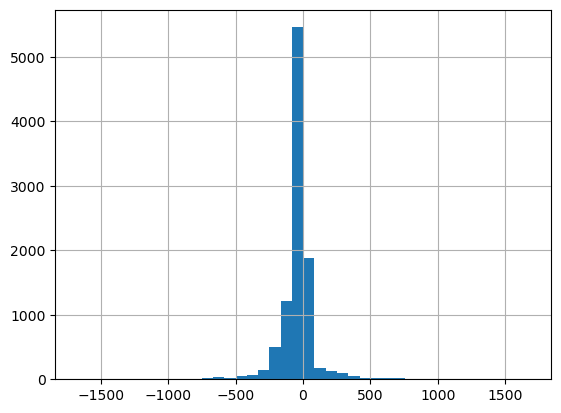

In [8]:
# Inner join on datetime and sensor to see which ones overlap
overlap = pd.merge(sensor_counts_old, sensor_counts_new, on=['datetime', 'sensor_id'], suffixes=('_old', '_new'), how='inner')
# Check if the hourly_counts are the same for overlapping rows
overlap['counts_match'] = overlap['hourly_counts_old'] == overlap['hourly_counts_new']
overlap['diff'] = overlap.hourly_counts_old - overlap.hourly_counts_new
# Display overlapping entries and whether the counts match
#overlap.loc[overlap.counts_match == False, ['datetime', 'sensor_id', 'hourly_counts_old', 'hourly_counts_new', 'counts_match']]
assert np.sum(np.array(overlap.counts_match)==False) + sum(overlap.counts_match) == len(overlap), "Something has gone wrong with the overlap"
print(f"Only {np.sum(np.array(overlap.counts_match)==False)} unequal entries of {len(overlap)}.")
# Histogram of the difference in counts
overlap.loc[overlap.counts_match == False, 'diff'].hist(bins=40)

There is some overlap but it is insubstantial so just use the original data.

Now merge them, giving priority to the original data for any overlapping entries.

In [9]:
# Sanity checks before doing the merge
a = pd.concat([sensor_counts_old, sensor_counts_new])
#dups = a.groupby(['datetime', 'sensor_id']).size().reset_index(name='count')
#dups = dups.loc[dups['count'] > 1,:]
#dups["RowNo"] = [x for x in range(len(dups))]
b = a.drop_duplicates(subset=['datetime', 'sensor_id'], keep='first')

assert len(a) == len(sensor_counts_old) + len(sensor_counts_new), "New length doesn't equal old sums"
assert len(b) == len(a) - len(overlap), f"b: {len(b)}, a: {len(a)}, overlap: {len(overlap)}"

del a, b

In [10]:
sensor_counts = pd.concat([sensor_counts_old, sensor_counts_new]).drop_duplicates(subset=['datetime', 'sensor_id'], keep='first')
sensor_counts

,datetime,year,month,mdate,day,time,sensor_id,hourly_counts
0,2019-11-01 17:00:00,2019,November,1,Friday,17,34,300
1,2019-11-01 17:00:00,2019,November,1,Friday,17,39,604
2,2019-11-01 17:00:00,2019,November,1,Friday,17,37,216
3,2019-11-01 17:00:00,2019,November,1,Friday,17,40,627
4,2019-11-01 17:00:00,2019,November,1,Friday,17,36,774
...,...,...,...,...,...,...,...,...
1850385,2024-03-22 15:00:00,2024,March,22,Friday,15,45,1388
1850388,2023-05-27 13:00:00,2023,May,27,Saturday,13,63,1052
1850389,2024-03-23 16:00:00,2024,March,23,Saturday,16,50,557
1850390,2024-04-17 16:00:00,2024,April,17,Wednesday,16,20,478


#### Identify new sensors

Some new sensors have been introduced, mark them

In [11]:
new_sensors = set(sensor_counts_new.sensor_id.unique()) - set(sensor_counts_old.sensor_id.unique())
print(f"New sensors: {new_sensors}")

sensor_counts['new_sensor'] = sensor_counts['sensor_id'].isin(new_sensors)

New sensors: {130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 161, 107, 108, 109, 117, 118, 123, 124}


### Get sensor locations

There are old and new locations. Some of the old locations are missing from the old ones (really annoying) so they need to be concatenated.

In [12]:
sensor_locations_old = pd.read_csv('../../Data/FootfallData/melbourne_locations.csv')  # Old locations
sensor_locations_new = pd.read_csv('../../Data/FootfallData/pedestrian-counting-system-sensor-locations.csv')

# Only keep the columns we need
sensor_locations_old.drop(['direction_1', 'direction_2', 'Start', 'End', 'Values_per_sensor', 'Cluster_num_5clusters'], axis = 1, inplace = True)
sensor_locations_new.drop(['Direction_1', 'Direction_2'], axis = 1, inplace = True)
# There are a few new duplicate sensors now that the direction information has been removed. 
sensor_locations_new.drop_duplicates(keep="first", inplace=True)
sensor_locations_new['Location'] = sensor_locations_new['Location'].apply(lambda x: f"({x})")  # Location needs brackets round it for consistency

# Check no duplicate IDs any more
assert len(sensor_locations_old.sensor_id.unique()) == len(sensor_locations_old)
assert len(sensor_locations_new.Location_ID.unique()) == len(sensor_locations_new)

# Rename some columns in the new data
sensor_locations_new.rename({
    "Location_ID": "sensor_id",
    "Sensor_Description": "Name",
    "Sensor_Name": "sensor_name",
    "Installation_Date": "installation_date",
    "Location": "location"
}, axis = 1, inplace = True)

sensor_locations = pd.concat([sensor_locations_old, sensor_locations_new]).drop_duplicates(subset=['sensor_id'], keep='first')

sensor_locations

,sensor_id,Name,sensor_name,installation_date,status,note,Latitude,Longitude,location,Note,Location_Type,Status
0,16,Australia on Collins,Col270_T,30/03/2009,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.965210,"(-37.81573422, 144.96521044)",NaN,NaN,NaN
1,50,Faraday St-Lygon St (West),Lyg309_T,30/11/2017,A,NaN,-37.798082,144.967210,"(-37.79808191, 144.96721014)",NaN,NaN,NaN
2,73,Bourke St - Spencer St (South),Bou655_T,02/10/2020,I,NaN,-37.816957,144.954154,"(-37.81695684, 144.95415373)",NaN,NaN,NaN
3,66,State Library - New,QVN_T,06/04/2020,A,NaN,-37.810578,144.964443,"(-37.81057845, 144.96444294)",NaN,NaN,NaN
4,59,Building 80 RMIT,RMIT_T,13/02/2019,A,NaN,-37.808256,144.963049,"(-37.80825648, 144.96304859)",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
128,140,COM Pole 2837 - Boyd Park,Boyd2837_T,2023-11-02,NaN,NaN,-37.825910,144.961860,"(-37.82590962, 144.96185972)",NaN,Outdoor,A
129,150,narrm ngarrgu Library - Level 1 Main Stairs B,narrLibL1MB_T,2023-10-23,NaN,NaN,-37.807912,144.958201,"(-37.80791198, 144.95820087)",NaN,Indoor,A
130,152,narrm ngarrgu Library - Level 2 - Study Area L...,narrLibL2S1_T,2023-10-23,NaN,NaN,-37.807767,144.958440,"(-37.80776728, 144.95843977)",NaN,Indoor,A
131,154,narrm ngarrgu Library - Level 3 Children's Lib...,narrLibL3C1_T,2023-10-23,NaN,NaN,-37.807784,144.958628,"(-37.80778437, 144.95862772)",NaN,Indoor,A



#### Join count data to sensor locations so that location and count info in same place

In [13]:
location_counts = pd.merge(sensor_locations, sensor_counts, on='sensor_id', how='inner')
# Stuff in comments was useful to find out why the join didn't work properly (problems concatenating the old and new data)
#location_counts = pd.merge(sensor_locations, sensor_counts, on='sensor_id', how='outer', indicator=True)

# Check if there are any rows that didn't merge from either dataframe
#left_only = location_counts[location_counts['_merge'] == 'left_only']
#right_only = location_counts[location_counts['_merge'] == 'right_only']

assert len(location_counts) == len(sensor_counts), f"Location counts length ({len(location_counts)} doesn't match sensor counts length ({len(sensor_counts)})"
location_counts

,sensor_id,Name,sensor_name,installation_date,status,note,Latitude,Longitude,location,Note,Location_Type,Status,datetime,year,month,mdate,day,time,hourly_counts,new_sensor
0,16,Australia on Collins,Col270_T,30/03/2009,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.96521,"(-37.81573422, 144.96521044)",NaN,NaN,NaN,2011-01-01 00:00:00,2011,January,1,Saturday,0,744,False
1,16,Australia on Collins,Col270_T,30/03/2009,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.96521,"(-37.81573422, 144.96521044)",NaN,NaN,NaN,2011-01-01 01:00:00,2011,January,1,Saturday,1,444,False
2,16,Australia on Collins,Col270_T,30/03/2009,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.96521,"(-37.81573422, 144.96521044)",NaN,NaN,NaN,2011-01-01 02:00:00,2011,January,1,Saturday,2,263,False
3,16,Australia on Collins,Col270_T,30/03/2009,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.96521,"(-37.81573422, 144.96521044)",NaN,NaN,NaN,2011-01-01 03:00:00,2011,January,1,Saturday,3,169,False
4,16,Australia on Collins,Col270_T,30/03/2009,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.96521,"(-37.81573422, 144.96521044)",NaN,NaN,NaN,2011-01-01 04:00:00,2011,January,1,Saturday,4,79,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5480637,140,COM Pole 2837 - Boyd Park,Boyd2837_T,2023-11-02,NaN,NaN,-37.825910,144.96186,"(-37.82590962, 144.96185972)",NaN,Outdoor,A,2024-04-02 15:00:00,2024,April,2,Tuesday,15,160,True
5480638,140,COM Pole 2837 - Boyd Park,Boyd2837_T,2023-11-02,NaN,NaN,-37.825910,144.96186,"(-37.82590962, 144.96185972)",NaN,Outdoor,A,2024-09-03 12:00:00,2024,September,3,Tuesday,12,149,True
5480639,140,COM Pole 2837 - Boyd Park,Boyd2837_T,2023-11-02,NaN,NaN,-37.825910,144.96186,"(-37.82590962, 144.96185972)",NaN,Outdoor,A,2024-05-23 05:00:00,2024,May,23,Thursday,5,3,True
5480640,140,COM Pole 2837 - Boyd Park,Boyd2837_T,2023-11-02,NaN,NaN,-37.825910,144.96186,"(-37.82590962, 144.96185972)",NaN,Outdoor,A,2024-05-30 05:00:00,2024,May,30,Thursday,5,5,True


#### It could be useful to drop sensors that do not have as many recorded countsfor now leaving them in, but may drop in the future

#### Order by datetime column

In [14]:
location_counts = location_counts.sort_values(by=['datetime'])
location_counts.reset_index(inplace = True, drop = True)

### Clean and save data

In [15]:
# location_counts.drop(['Latitude', 'Longitude', 'location'], axis = 1, inplace =True)
# location_counts.rename({'day': 'weekday', 'mdate': 'day', 'time': 'hour'}, axis =1, inplace = True)

# Change month to integers 1-12
months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June':6, 'July': 7, 'August': 8,
         'September': 9, 'October': 10, 'November': 11, 'December': 12}

location_counts.month = location_counts.month.map(months)

In [17]:
os.makedirs(os.path.dirname("../../Cleaned_data/SensorData/"), exist_ok=True)

just_some_sensors = location_counts[location_counts['sensor_id'].isin([2,6,8,9,10,11,18])]
just_some_sensors.to_csv("../../Cleaned_data/SensorData/validsensors.csv",index=False)
location_counts.to_csv("../../Cleaned_data/SensorData/allsensors.csv",index=False)

In [ ]:
# # Get data for just one sensor
# one_sensor =  location_counts[location_counts.sensor_id == 4]
# one_year = one_sensor[one_sensor.year==2010]
# # Set the datetime as the index
# one_sensor.set_index('datetime', inplace = True)
# duplicates = one_sensor[one_sensor.index.duplicated()]
# for day in duplicates.mdate.unique():
#     one_day = duplicates[duplicates.mdate == day]
#     print(day, len(one_day))

## Outlier removal

(_I think this is redundant now, performed before modelling_)

TODO: Remove following this redundant outlier removal code?

In [ ]:
def doubleMADsfromMedian(y,thresh=3.5):
    """Find outliers using the Median Average Distance.
    
    VALUE: return a list of true/false denoting whether the element in y is an outlier or not
    
    PARAMETERS:
      - y is a pandas Series, or something like that.
    
    warning: this function does not check for NAs
    nor does it address issues when 
    more than 50% of your data have identical values
    """
    # Calculate the upper and lower limits
    m = np.median(y) # The median
    abs_dev = np.abs(y - m) # The absolute difference between each y and the median
    # The upper and lower limits are the median of the difference
    # of each data point from the median of the data
    left_mad = np.median(abs_dev[y <= m]) # The left limit (median of lower half)
    right_mad = np.median(abs_dev[y >= m]) # The right limit (median of upper half)
    
    # Now create an array where each value has left_mad if it is in the lower half of the data,
    # or right_mad if it is in the upper half
    y_mad = left_mad * np.ones(len(y)) # Initially every value is 'left_mad'
    y_mad[y > m] = right_mad # Now larger values are right_mad

    # Calculate the z scores for each element
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    
    # Return boolean list showing whether each y is an outlier
    return modified_z_score > thresh

# Make a list of true/false for whether the footfall is an outlier
no_outliers = pd.DataFrame(doubleMADsfromMedian(original['InCount']))
no_outliers.columns = ['outlier'] # Rename the column to 'outlier'

# Join to the original footfall data to the list of outliers, then select a few useful columns
join = pd.concat([original, no_outliers], axis = 1)
join = pd.DataFrame(join, columns = ['Day_yr', 'outlier', 'InCount'])

# Choose just the outliers
outliers = join[join['outlier'] == True]
outliers_list = list(outliers['Day_yr']) # A list of the days that are outliers

# Now remove all outliers from the original data
df = original.loc[~original['Day_yr'].isin(outliers_list)]
df = df.reset_index(drop = True)

# Check that the lengths all make sense
assert(len(df) == len(original)-len(outliers_list))

print("I found {} outliers from {} days in total. Removing them leaves us with {} events".format(\
    len(outliers_list), len(join), len(df) ) )